***Note: this is the fECR.ipynb notebook. The
PDF version "Enzyme-catalysed reaction: analysis as a feedback control
actuator"
is available [here](fECR.pdf).***

# Introduction
Using the methods of control theory to examine and reexamine the behaviour of living systems is well-established
<cite data-cite="Cra47a">(Craik, 1947)</cite>
<cite data-cite="Wie61">(Weiner, 1961)</cite>
<cite data-cite="Bay66">(Bayliss, 1966)</cite>
<cite data-cite="Sav09">(Savageau, 1976)</cite>
<cite data-cite="JagFla03">(Jagacinski and Flach, 2003)</cite>
<cite data-cite="IglIng10">(Inglesias and Ingalls, 2010)</cite>
<cite data-cite="WelBulKalMasVer08">(Wellstead et al, 2008)</cite>
<cite data-cite="DriLeaDet15">(Drion et al, 2015)</cite>
<cite data-cite="Vec13">(Del Veccio, 2013)</cite>.
This notebook examines the enzyme-catalysed reaction as a control actuator and its behavior within a feedback loop controlling product concentration.


As discussed by <cite data-cite="GawCra16">(Gawthrop and Crampin, 2016)</cite>:
"The bond graph approach gives the set of *nonlinear* ordinary
differential equations describing the biomolecular system being modelled.
Linearisation of non-linear systems is a standard technique in control
engineering: as discussed by 
<cite data-cite="GooGraSal01">(Goodwin, Graebe and Salgado)</cite>, 
"The incentive to
try to approximate a nonlinear system by a linear model is that the
science and art of linear control is vastly more complete and simpler
than they are for the nonlinear case.". Nevertheless, it is important
to realise that conclusions drawn from linearisation can only be
verified using the full *nonlinear* equations."

Linearisation *per se* is discussed in the notebook [Linearisation](https://github.com/gawthrop/BondGraphTools-Biomolecular/blob/master/Linearisation.ipynb).
In particular, linearisation of a dynamic system $\dot x = f(x,v)$ is with reference to a steady state defined by constant states $x=x_{ss}$ and constant flows $v=v_{ss}$ such that $f(x_{ss},v_{ss})=0$. In general, determination of steady-states is a difficult problem and can only be determined numerically; this is the approach taken here.


## Import some python code
The bond graph analysis uses a number of Python modules:

In [1]:
## Some useful imports
import BondGraphTools as bgt
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import IPython.display as disp

## Stoichiometric analysis
import stoich as st

## SVG bg representation conversion
import svgBondGraph as sbg

## Control systems package
import control as con

## Set quiet=False for verbose output
quiet = True

## Set slycot=True if slycot is installed (see control module)
slycot=True

## For reimporting: use imp.reload(module)
import importlib as imp

## Printing options
np.set_printoptions(precision=3)
fmt = '{:5.3f}'

## Allow output from within functions
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Product removal
productRemoval = True

## Feedback control


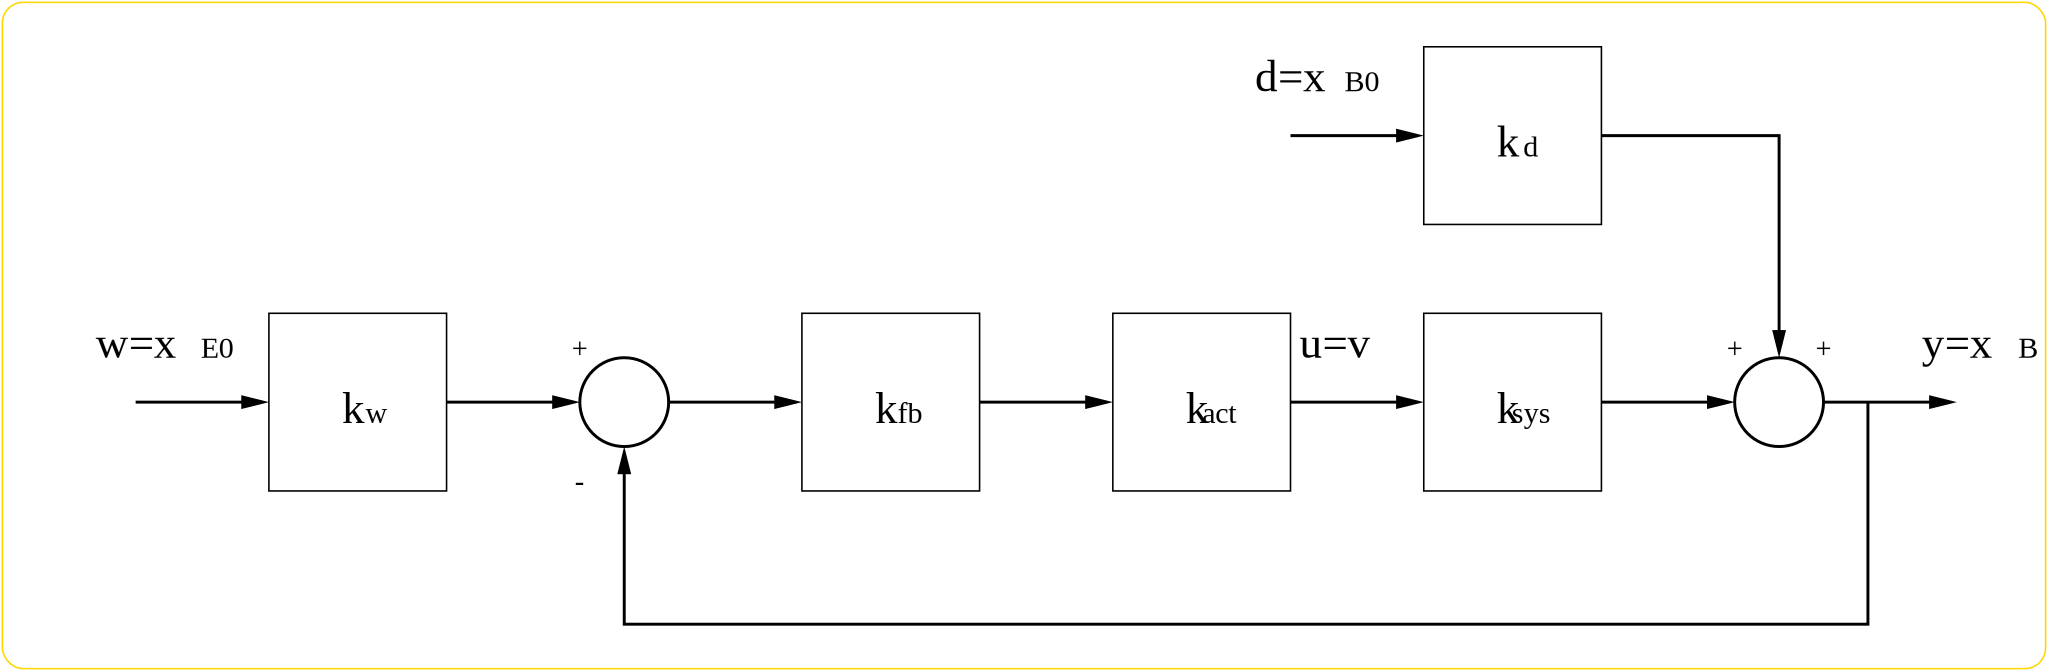

In [2]:
disp.SVG('feedback.svg')

The figure shows a feedback control loop. In terms of control theory, $k_{fb}$, $k_{act}$, $k_{sys}$, $k_d$ and $k_w$ are the feedback, actuator, system, disturbance and setpoint gains respectively; $u$,$y$ and $w$ are the control signal, system output and setpoint respectively. The blocks can be intepreted as static gains (for steady-state analysis) or as transfer functions for dynamic analysis.

As discussed below this diagram has a systems biology interpretation for the particular example considered here; in particular: $k_{fb}$ and $k_w$ are associated with a linearised feedback inhibition, $k_{act}$ with an enzyme-catalysed reaction and $k_{sys}$ and $k_{sys}$ and $k_d$ with product removal.

Defining the loop-gain $L = k_{fb}k_{act}k_{sys}$, it follows that:
\begin{align}
y &= \frac{L}{1+L} k_w w + \frac{1}{1+L}k_d d
\end{align}
Thus a large loop gain $L$ leads to:
\begin{align}
y &\approx k_w w 
\end{align}
The disturbance is eliminated whilst the system output follows $k_w w$.

It is important to emphasise that the actuator requires power to operate in the correct manner.

## Analysis functions
The folowing functions are used to analyse the various systems.

### Stoichiometry
This function returns the bond graph stoichiometry without chemostats **s**, with chemostats **sc** and with flowstats **sf** using the [stoich](https://github.com/gawthrop/BondGraphTools-Biomolecular/blob/master/stoich.ipynb) package and [BondGraphTools](https://pypi.org/project/BondGraphTools/).

In [3]:
def stoichiometry(abg,chemostats=[],flowstats=[]):
    s = st.stoich(abg.model(),quiet=quiet)
    sc = st.statify(s,chemostats=chemostats)
    
    if len(flowstats) is 0:
        sf = None
    else:
        sf = st.statify(s,flowstats=flowstats)
        
    return s,sc,sf

### Linearise about the steady-state
The bond graph model in stoichiometric form is symbolically linearised and combined with numerical parameters to give a linear system in numerical state-space form. The [Python Control Systems Library](https://pypi.org/project/control/) is used to convert the state-space systems into transfer functions and to give the steady-state (DC) gain.

In [4]:
def plot(t_step,vv,KK_F,title,ylabel='$v$'):
    """Plot step responses of linearised systems"""
    plt.plot(t_step,vv.T) 
    plt.title(title)
    Legend = ['K_F='+str(K_F) for K_F in KK_F]
    plt.legend(Legend)
    plt.grid()
    plt.xlabel('$t$')
    plt.ylabel(ylabel)
    plt.show()
    
def linearise(s,sc,sf=None,i_r=2,dist='B',t_step_max=10,KK_F=[10,100,1000]):
    """Linearise systems, generate transfer functions, plot step responses"""
    useFlowstat = sf is not None
    productRemoval = 'B0' in s['species'] 
    
    ## Steady state via long simulation
    ##Time
    t_max = int(1e3)
    t = np.linspace(0,t_max,1000)
    t_step = np.linspace(0,t_step_max,1000)
    
    if useFlowstat:
        ## Flowstat
        f0 = 0
        V_flow = {'r0':str(f0)}
        #print(V_flow)
        stats = sc['chemostats']+sf['flowstats']
        #print(stats)
        inp = 'r0'
    else:
        stats = sc['chemostats']
        inp = 'E0'
        
    ## index of input
    i_in = stats.index(inp)
    ##print('i_in',i_in)

    ## index of disturbance
    i_dist = stats.index(dist)
    #print('i_dist',i_dist)
    
    for K_F in KK_F:
        parameter['K_F'] = K_F
        parameter['K_G'] = 1/K_F
        print('\n==========================')
        print('K_F =',K_F)
        print('==========================')

        ## Simulate to get the steady state
        if useFlowstat:
            ssdat = st.sim(s,sc=sc,t=t,parameter=parameter,V_flow=V_flow,quiet=quiet)
        else:
            ssdat = st.sim(s,sc=sc,t=t,parameter=parameter,quiet=quiet)

        ## Use the final value as the steady-state
        x_ss = ssdat['X'][-1,:]
#         print(s['species'])
#         print('x_ss =', x_ss)
        v_ss = ssdat['V'][-1,:]
#        print('v_ss =', v_ss)


        ## Linearise: Sys is the linearised system in control toolbox form
        ## Flow output
        Sys = st.lin(s,sc,sf=sf,x_ss=x_ss,parameter=parameter,outvar='V',quiet=quiet)
        ## Potential output
        SysX = st.lin(s,sc,sf=sf,x_ss=x_ss,parameter=parameter,outvar='X',quiet=quiet)
        
        #con.ss2tf(Sys)
        tf = con.ss2tf(Sys)
        tfPhi = con.ss2tf(SysX)
        
        if useFlowstat:
            deriv = con.tf([1,0],[1])
            tf_f_in = con.minreal(con.series(deriv,tf[i_r,i_in]))
            tf_f_dist = con.minreal(tf[i_r,i_dist])
            inName = 'f_0'
        else:
            tf_f_in = con.minreal(tf[i_r,i_in])
            tf_f_dist = con.minreal(tf[i_r,i_dist])
            inName = 'x_E0'
                 
        if productRemoval:
            ## Compute transfer functions to B
            i_B = s['species'].index('B')
            print('i_B',i_B,'i_dist',i_dist)

            tf_X_in = tfPhi[i_B,i_in]
            print('\nTransfer function: phi_B/input',tf_X_in)
            in_gain_X = con.dcgain(tf_X_in)
            print('\tgain:',fmt.format(in_gain_X))
            print('\tpoles:', con.pole(tf_X_in))
            
            tf_X_dist = tfPhi[i_B,i_dist]
            print('\nTransfer function: phi_B/phi_B0',tf_X_dist)
            dist_gain_X = con.dcgain(tf_X_dist)
            print('\tgain:',fmt.format(dist_gain_X))
            
            tf_in = tf_X_in
            
        else:
            dist_gain_X = None
            in_gain_X= None
            print('\nTransfer function: f_2/'+inName,tf_f_in)
            in_gain = con.dcgain(tf_f_in)
            print('\tgain:',fmt.format(in_gain))
            print('\tpoles:', con.pole(tf_f_in))
            
            print('\nTransfer function: f_2/x_B',tf_f_dist)
            dist_gain = con.dcgain(tf_f_dist)
            print('\tgain:',fmt.format(dist_gain))
        
            tf_in = tf_f_in
            
        ## Step responses
        if productRemoval:
            t,p = con.step_response(tf_X_in,T=t_step)
            t,pd = con.step_response(tf_X_dist,T=t_step)
        else:
            t,v = con.step_response(tf_f_in,T=t_step)
            t,vd = con.step_response(tf_f_dist,T=t_step)
        
        if K_F is KK_F[0]:
            if productRemoval:
                pp = p
                ppd = pd
            else:
                vv = v
                vvd = vd    
        else:

            if productRemoval:
                pp = np.vstack((pp,p))
                ppd = np.vstack((ppd,pd))
            else:
                vv = np.vstack((vv,v))
                vvd = np.vstack((vvd,vd))

    if productRemoval:
        plot(t_step,pp,KK_F,'Control response  -- X',ylabel='$X$') 
        plot(t_step,ppd,KK_F,'Disturbance response -- X',ylabel='$X$') 
    else:
        plot(t_step,vv,KK_F,'Control response -- flow',ylabel='$v$') 
        plot(t_step,vvd,KK_F,'Disturbance response -- flow',ylabel='$v$') 
    
    return Sys,SysX,x_ss,v_ss,dist_gain_X,in_gain_X,tf_in

def extractSS(s,x_ss,species):
    code = ''
    for spec in species:
        ss = x_ss[s['species'].index(spec)]
        name = 'x_ss_'+spec
        print(name+' =',fmt.format(ss))
        #exec(name+' = '+str(ss))
        code += name+' = '+str(ss)+'\n'
    #print(code)
    return code


#  Pumped enzyme-catalysed reaction: analysis as a control actuator
The bond graph representation of the (reversible) enzyme-catalysed reaction is given by
<cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite> and is discussed in the tutorial [ECR](ECR.ipynb).

The additional species $E0$ represents a reservoir of enzyme coupled to the ECR via the reaction $r0$. 
$E0$ is used as a chemostat to adjust the total amount of enzyme associated with the ECR.
The additional species F and G act as a *pump* -- the idea is that a high potential of F and a low potential of G will drive the reaction $A \leftrightarrow B$ strongly towards B and thus endow the reaction with desirable actuator properties.

Following <cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite>, the steady-state flow $v$ through r1 and r2 is:
\begin{align}
 v &=  \bar{\kappa} \frac{K_C e_0}{\frac{K_C}{K_E} +  \sigma_v} \delta_v\\
 \text{where }
  \delta_v &= v_o^+ - v_o^-\\
 \sigma_v &= \frac{\kappa_1 v_o^+ + \kappa_2 v_o^-}{\kappa_1  +
   \kappa_2}\\
   \text{and, in this case }
   v_o^+ &= K_A K_F x_A x_F \; , v_o^- = K_B K_G x_A x_G
\end{align}
Further
\begin{align}
 e_0 &= (1 + \frac{K_E}{K_C} \sigma_v) x_E = (1 + \frac{K_e}{K_c} \sigma_v) \frac{K_{E0}}{K_E}x_{E0}
\end{align}
Now, as discussed above $K_F$ is large and $K_G$ small hence:
\begin{align}
v &\approx k_{act} x_E = k_{act} \frac{K_{E0}}{K_E} x_{E0} \label{eq:v_act}\\
\text{where }
k_{act} &=
\bar{\kappa} \sigma_v K_E x_E
\end{align}
In the particular case where $\kappa_1=\kappa_2=\kappa$

\begin{align}
k_{act} &= \frac{\kappa}{2} K_A K_F x_A x_F K_E 
\end{align}



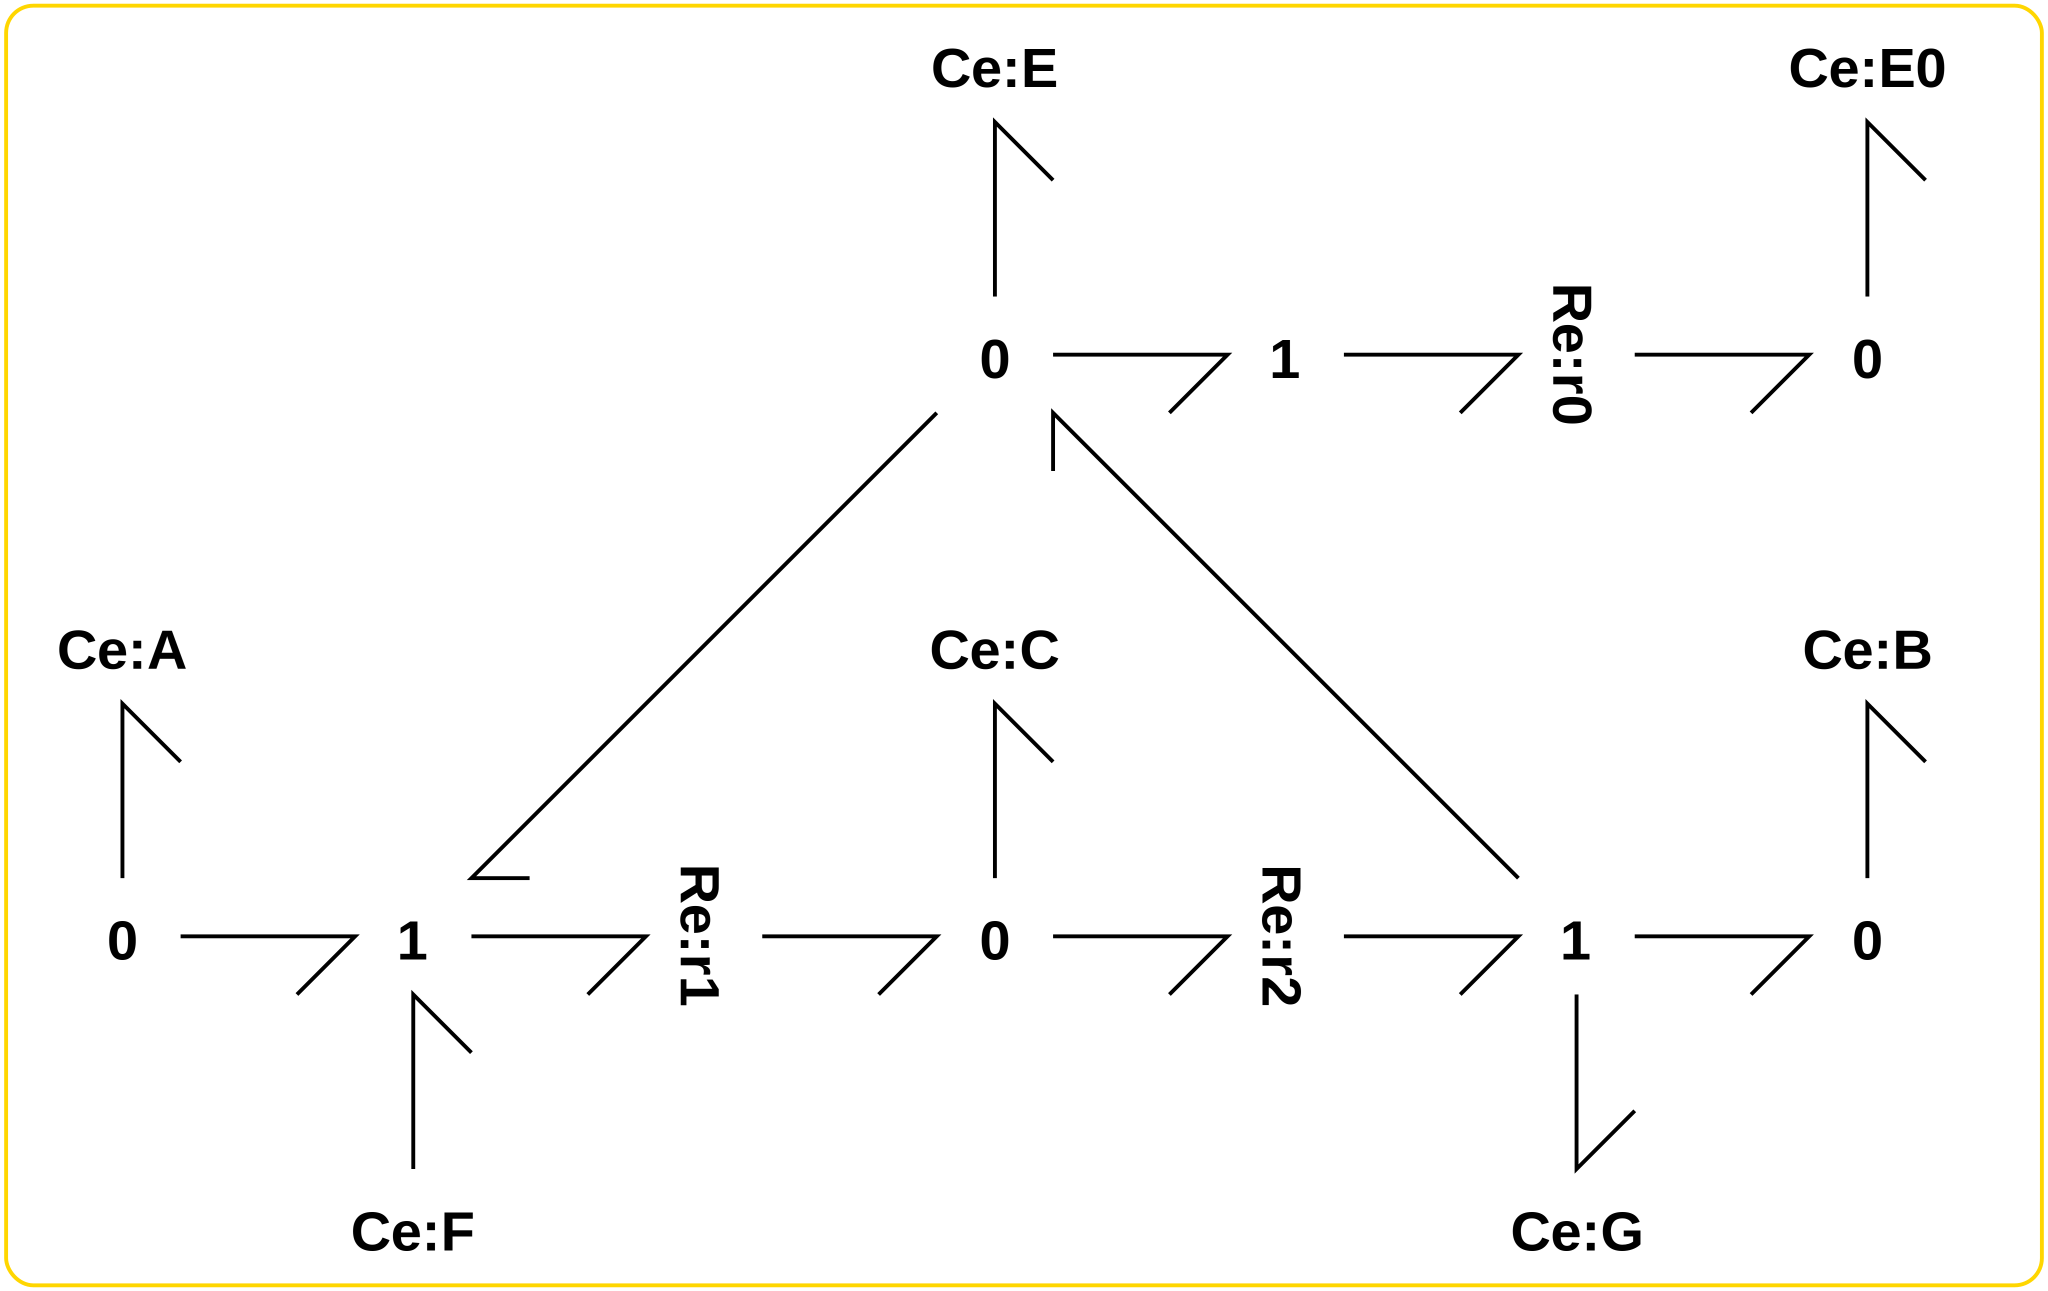

In [5]:
sbg.model('pRE_abg.svg')
import pRE_abg
abg = pRE_abg
disp.SVG('pRE_abg.svg')

## Numerical Parameters

In [6]:
## Parameters
X0_A = 2
K_A = 1
X0_E0 = 1
K_B = 10
K_E0 = 1
K_C = 1
K_E = 1
K_F = 100
KK_F = [10,100]
K_G = 1/K_F
kappa_r0 = 1

kappa = 10
kappa_r1 = kappa
kappa_r2 = kappa

pars = ['X0_A','K_E0','X0_E0','K_A','K_B','K_C','K_E','K_F','K_G','kappa_r0','kappa_r1','kappa_r2']
parameter = {}
for par in pars:
    parameter[par] = eval(par)
print(parameter)

{'X0_A': 2, 'K_E0': 1, 'X0_E0': 1, 'K_A': 1, 'K_B': 10, 'K_C': 1, 'K_E': 1, 'K_F': 100, 'K_G': 0.01, 'kappa_r0': 1, 'kappa_r1': 10, 'kappa_r2': 10}


## Analyse

None
Reactions:


<IPython.core.display.Latex object>

Pathway reaction:


<IPython.core.display.Latex object>


K_F = 10
0 states have been removed from the model
0 states have been removed from the model

Transfer function: f_2/x_E0 
  -10 s + 1900
----------------
s^2 + 231 s + 20

	gain: 95.000
	poles: [-2.309e+02 -8.661e-02]

Transfer function: f_2/x_B 
-10 s^2 - 2110 s - 100
----------------------
   s^2 + 231 s + 20

	gain: -5.000

K_F = 100
0 states have been removed from the model
0 states have been removed from the model

Transfer function: f_2/x_E0 
  -s + 1.999e+04
-----------------
s^2 + 2022 s + 20

	gain: 999.500
	poles: [-2.022e+03 -9.891e-03]

Transfer function: f_2/x_B 
-0.993 s^2 - 1997 s - 9.93
--------------------------
    s^2 + 2022 s + 20

	gain: -0.497


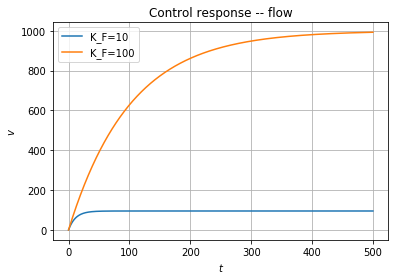

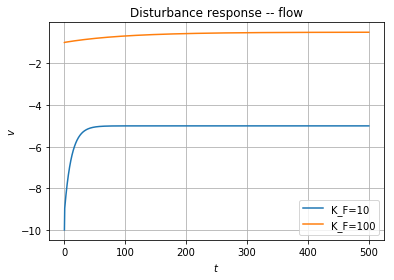

x_ss_A = 2.000
x_ss_F = 1.000
k_act = 1000.0


In [7]:
chemostats=['E0','A','B','F','G']
# flowstats = []
s,sc,sf = stoichiometry(abg,chemostats=chemostats)
print(sf)
print('Reactions:')
disp.Latex(st.sprintrl(s))
sp = st.path(s,sc)
print('Pathway reaction:')
disp.Latex(st.sprintrl(sp))
Sys,SysX,x_ss,v_ss,dist_gain_X,in_gain_X,tf_in_act = linearise(s,sc,i_r=2,dist='B',KK_F=KK_F,t_step_max=500)

## Actuator gain
exec(extractSS(s,x_ss,['A','F']))
k_act = (kappa/2)*K_A*K_E*K_F*x_ss_A*x_ss_F
print('k_act =', k_act)

## Discussion.

- With the values given in the Parameters section, the theoretical steady-state flow $v$ is $1000 x_{E0}$.
- This agrees with the final value (1000) of the unit step response to $x_{E0}$ 
- This also agrees with the final value (~0) of the unit step response to $x_{B}$ 
- As there are two non-chemostated **Ce** components, the transfer function is second-order. 
- There are two real poles at about $s=-0.01$ and $s=-2000$. The slow pole (timeconstant about 100) corresponds to the approximate conserved moiety.
- Thus the ECR acts a nearly ideal actuator: the flow $v$ depends on $E0$ only in a linear fashion.
- However, the use of F and G to pump the actuator consumes energy - this is a typical performance/energy tradeoff in control systems.


#  Product removal.
The additional reaction **Re:R3** and species **Ce_BO** is added to the bond graph so that product B is removed. 
In the steady-state this means that $v = \kappa_3 (K_B x_B - K_{B0} x_{B0})$, hence:
\begin{align}
x_B &= k_{sys} v + k_{d}x_{B0}\\
\text{where }
k_{sys} &= \frac{1}{\kappa_3 K_B}\\
\text{and }
k_d &= \frac{K_{B0}}{K_B}
\end{align}


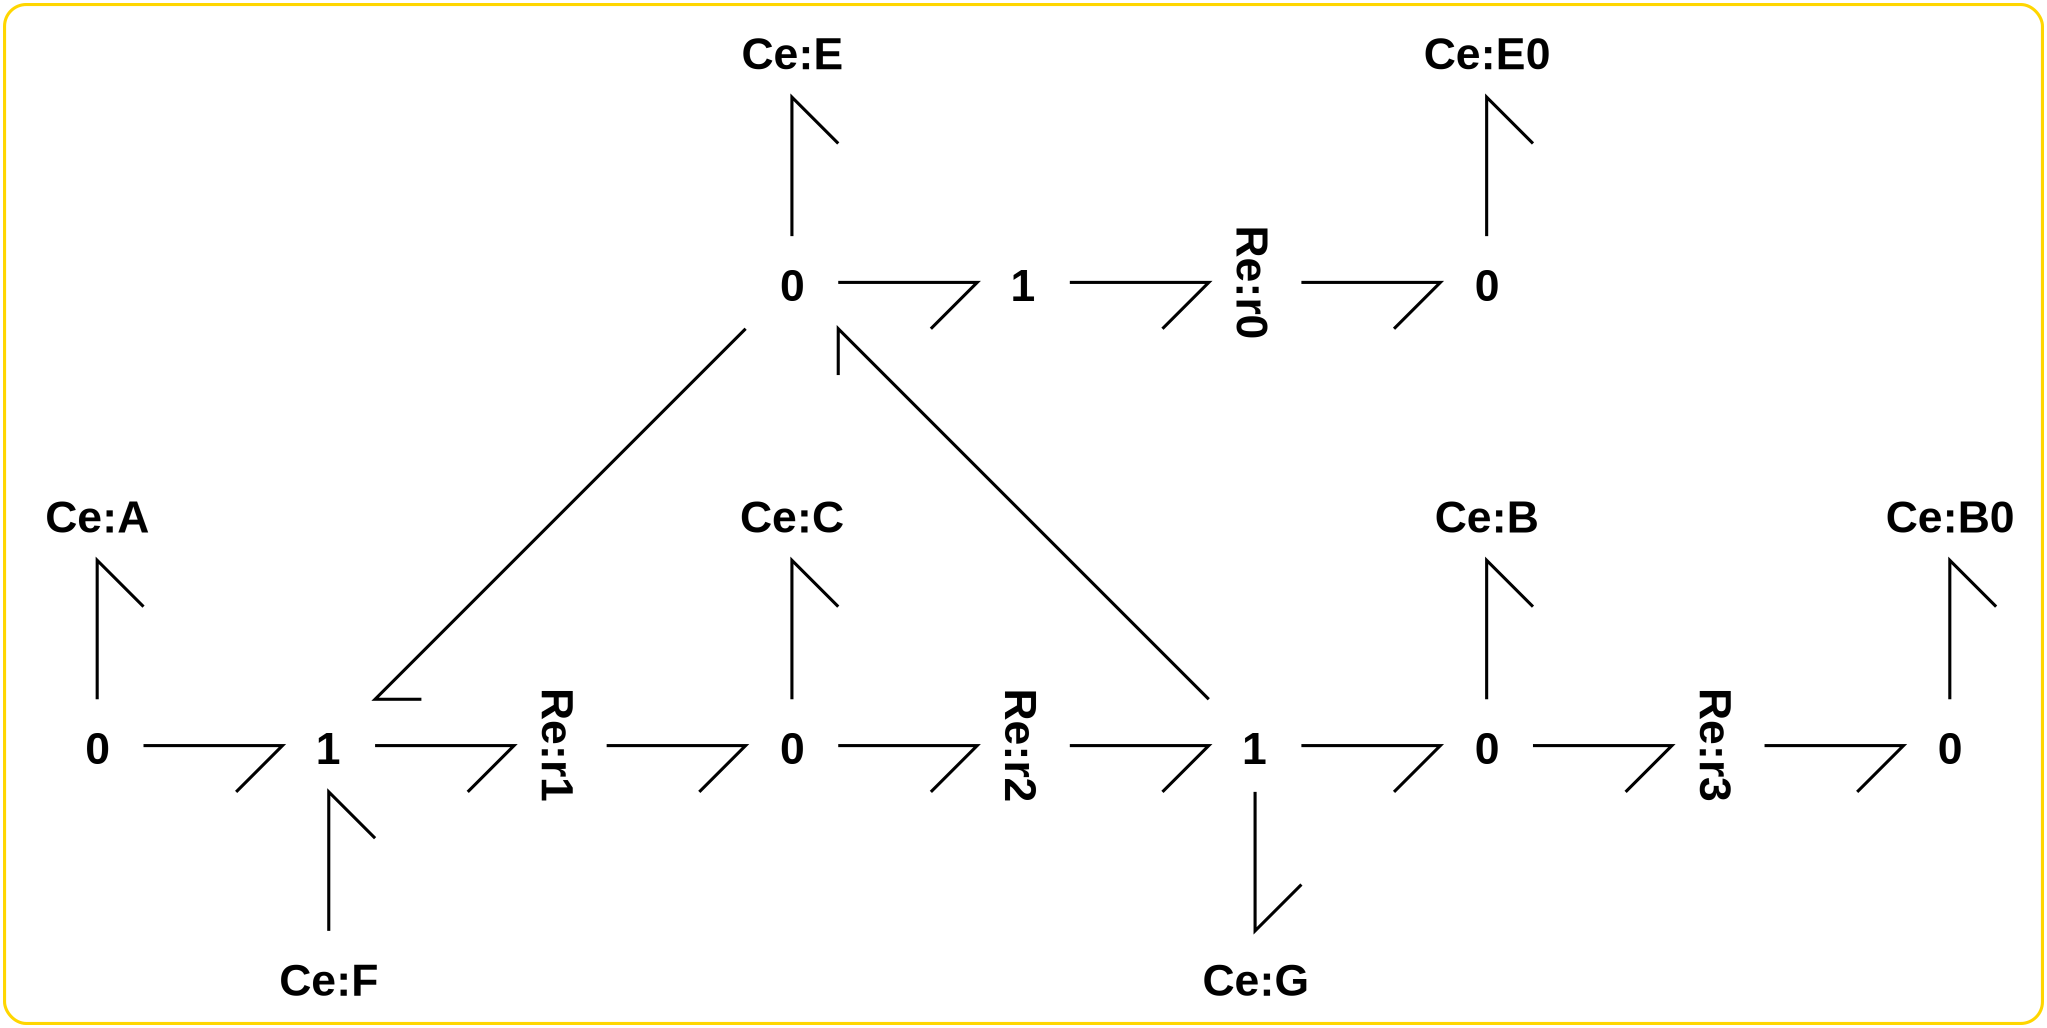

In [8]:
sbg.model('pREpr_abg.svg')
import pREpr_abg
abg = pREpr_abg
disp.SVG('pREpr_abg.svg')

## Numerical Parameters

In [9]:
## Parameters
K_B0 = 1
X0_B0 = 1e-6
kappa_r3 = 1

pars = ['K_B0','X0_B0','kappa_r3']
for par in pars:
    parameter[par] = eval(par)
#print(parameter)

## Analyse


K_F = 10
0 states have been removed from the model
0 states have been removed from the model
i_B 1 i_dist 2

Transfer function: phi_B/input 
3.331e-16 s^2 - 66.67 s + 1333
------------------------------
s^3 + 307.7 s^2 + 5007 s + 300

	gain: 4.444
	poles: [-2.904e+02 -1.718e+01 -6.014e-02]

Transfer function: phi_B/phi_B0 
      s^2 + 287.7 s + 20
------------------------------
s^3 + 307.7 s^2 + 5007 s + 300

	gain: 0.067


/home/peterg/.local/lib/python3.6/site-packages/scipy/signal/filter_design.py:1619: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)



K_F = 100
0 states have been removed from the model
1 states have been removed from the model
i_B 1 i_dist 2

Transfer function: phi_B/input 
-1.11e-16 s^2 - 95.23 s + 1.905e+04
-----------------------------------
s^3 + 2127 s^2 + 2.319e+04 s + 210

	gain: 90.704
	poles: [-2.116e+03 -1.095e+01 -9.062e-03]

Transfer function: phi_B/phi_B0 
        s^2 + 2116 s + 20
----------------------------------
s^3 + 2127 s^2 + 2.319e+04 s + 210

	gain: 0.095


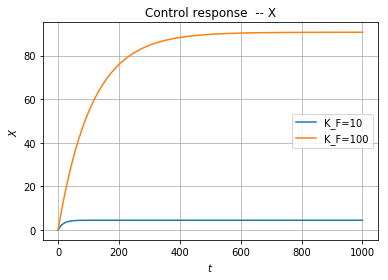

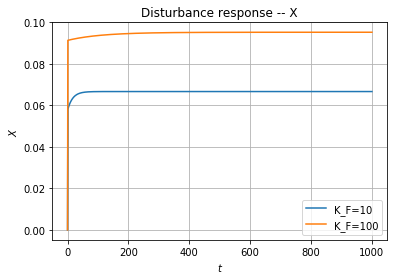

In [10]:
chemostats=['E0','A','B0','F','G']
s,sc,sf = stoichiometry(abg,chemostats=chemostats)
#print(sf)
Sys,SysX,x_ss,v_ss,dist_gain_X,in_gain_X,tf_in_pr = linearise(s,sc,i_r=3,dist='B0',t_step_max=1000,KK_F=KK_F)
#con.ss2tf(Sys)

In [11]:
print('\nComputed steady-state values:')
exec(extractSS(s,x_ss,['A','F','B','B0']))

print('\nThe control system gains:')
k_sys = 1/(kappa_r3*K_B)
k_dist = K_B0/K_B
print('k_sys =', fmt.format(k_sys))
print('k_dist =', fmt.format(k_dist))

print('Setpoint gain: Theory =', k_act*k_sys, ', Linearised=',fmt.format(in_gain_X ))
print('Disturbance gain: Theory =',k_dist, ', Linearised=',fmt.format(dist_gain_X ))


Computed steady-state values:
x_ss_A = 2.000
x_ss_F = 1.000
x_ss_B = 95.229
x_ss_B0 = 0.000

The control system gains:
k_sys = 0.100
k_dist = 0.100
Setpoint gain: Theory = 100.0 , Linearised= 90.704
Disturbance gain: Theory = 0.1 , Linearised= 0.095


## Discussion

- As there are three non-chemostated **Ce** components, the transfer function is third-order. 
- There are three real poles. The two at about $s=-0.01$ and $s=-2000$ corespond to the actuator, the third at about $s=-10$ corresponds to the product removal.
- If isolated, the product removal pole would be at $s = -\kappa_{r3}K_B=-10$. The degree of isolation depends on $K_F$ ($K_G=1/K_F$); large values of $K_F$ do indeed give a pole close to $s=-10$.
- The high gains and the lack of feedback lead to an ill-defined response and numerical issues


# Feedback Control

Feedback is added using the red bonds in the Figure. The reaction relating E and E0 now contains B:
\ch{E + N B <> [ r0 ] E0} where $N=5$.
In the steady state, this implies that:
\begin{align}
    K_E K_B^N x_E x_B^N = K_{E0} x_{E0}
\end{align}
For a given steady state this can be linearised to give:
\begin{align}
    K_E K_B^N (\bar{x}_B^N\tilde{x}_E  + \bar{x}_E N \bar{x}_B^{N-1} \tilde{x}_B) = K_{E0} \tilde{x}_{E0}
\end{align}
This can be rewritten as:
\begin{align}
\tilde{x}_E &= k_{fb} (k_{w}\tilde{x}_{E0} - \tilde{x}_B) \label{eq:fb}\\
\text{where }
k_{fb} &= N\frac{\bar{x}_E}{\bar{x}_B}\\
\text{and }
k_{w} &= \frac{1}{k_{fb}}\frac{K_{E0}}{ K_E K_B^N \bar{x}_B^{N} }
\end{align}

Equation \ref{eq:fb} represents negative feedback where:

- $k_b$ is the feedback gain
- $\tilde{x}_B$ is the controllled output and
- $k_{w}\tilde{x}_{E0}$ is the setpoint.

In system biology terms, this is an example of *feedback inhibition* with multiple binding sites.

<module 'fREpr_abg' from '/home/peterg/WORK/Research/SystemsBiology/Notes/2020/fECR/fREpr_abg.py'>

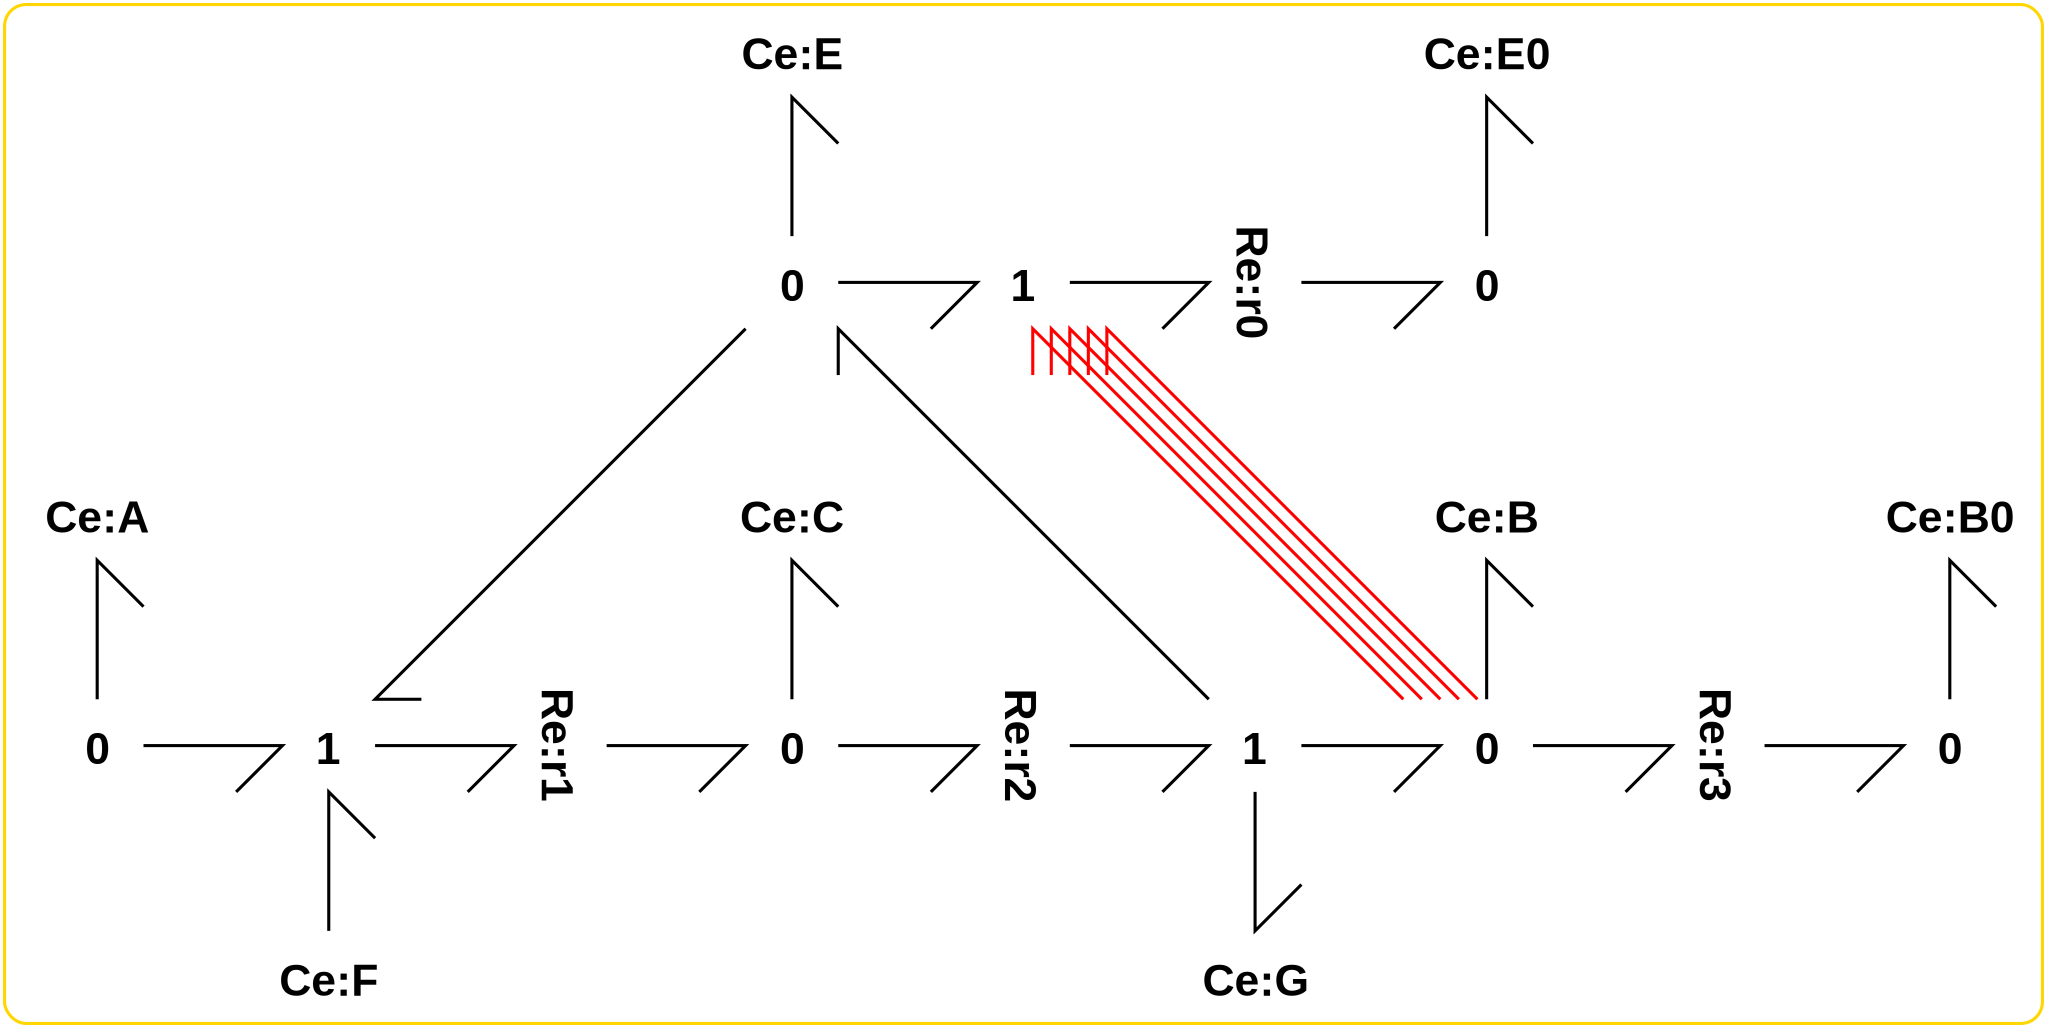

In [12]:
sbg.model('fREpr_abg.svg')
import fREpr_abg
imp.reload(fREpr_abg)
abg = fREpr_abg
disp.SVG('fREpr_abg.svg')

## Numerical Parameters

In [13]:
## Number of feedback bonds
N=5
K_E0 = K_B**N
parameter['K_E0'] = K_E0

## Analyse


K_F = 10
0 states have been removed from the model
1 states have been removed from the model
i_B 1 i_dist 2

Transfer function: phi_B/input 
     5e+05 s^2 + 1.158e+08 s + 1.855e+08
---------------------------------------------
s^3 + 2.365e+06 s^2 + 4.146e+08 s + 7.779e+08

	gain: 0.238
	poles: [-2.365e+06 -1.734e+02 -1.897e+00]

Transfer function: phi_B/phi_B0 
        s^2 + 6.401e+05 s + 1.28e+07
---------------------------------------------
s^3 + 2.365e+06 s^2 + 4.146e+08 s + 7.779e+08

	gain: 0.016

K_F = 100
0 states have been removed from the model
1 states have been removed from the model
i_B 1 i_dist 2

Transfer function: phi_B/input 
    5e+05 s^2 + 1.011e+09 s + 1.998e+09
-------------------------------------------
s^3 + 5.8e+06 s^2 + 2.485e+09 s + 5.566e+09

	gain: 0.359
	poles: [-5.800e+06 -4.263e+02 -2.251e+00]

Transfer function: phi_B/phi_B0 
       s^2 + 4.639e+06 s + 9.275e+07
-------------------------------------------
s^3 + 5.8e+06 s^2 + 2.485e+09 s + 5.566e+09

	ga

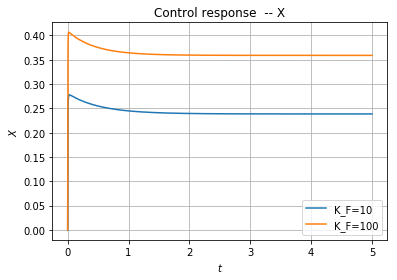

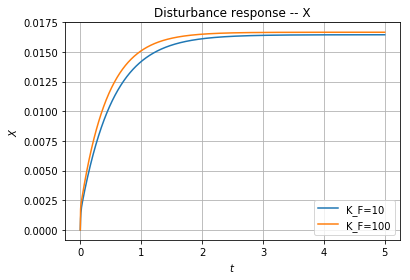

In [14]:
s,sc,sf = stoichiometry(abg,chemostats=chemostats)
Sys,SysX,x_ss,v_ss,dist_gain_X,in_gain_X,tf_in_fb = linearise(s,sc,sf=None,i_r=3,dist='B0',t_step_max=5,KK_F=KK_F)

## Control system analysis

In [15]:
print('\nComputed steady-state values:')
species = ['A','B','E','C','F']
exec(extractSS(s,x_ss,species))
print('\nThe control system gains:')
k_act = (kappa/2)*K_A*K_E*K_F*x_ss_A*x_ss_F
print('k_act =', fmt.format(k_act))
k_fb = N*(x_ss_E/x_ss_B)
print('k_fb =', fmt.format(k_fb))
k_sys = 1/(kappa_r3*K_B)
k_dist = K_B0/K_B
k_w = ((K_E0/K_E)/(K_B*x_ss_B)**N)/k_fb
print('k_sys =', fmt.format(k_sys))

print('\nFeedback loop analysis:')
L = k_act*k_fb*k_sys
print('L =', fmt.format(L))
print('L/(1+L) =', fmt.format(L/(1+L)))
print('Disturbance gain. Theory:',fmt.format(k_dist/(1+L)), ', Linearised:',fmt.format(dist_gain_X))
print('Setpoint gain.    Theory:',fmt.format(k_w*L/(1+L)), ', Linearised:', fmt.format(in_gain_X))



Computed steady-state values:
x_ss_A = 2.000
x_ss_B = 2.154
x_ss_E = 0.022
x_ss_C = 2.159
x_ss_F = 1.000

The control system gains:
k_act = 1000.000
k_fb = 0.050
k_sys = 0.100

Feedback loop analysis:
L = 5.005
L/(1+L) = 0.833
Disturbance gain. Theory: 0.017 , Linearised: 0.017
Setpoint gain.    Theory: 0.359 , Linearised: 0.359


## Discussion

- The system output $x_B$ has a well-defined response to both setpoint $w=x_{E0}$ and disturbance $d=x_{B0}$.
- The linear response steady-state gain is as predicted by the theory for the given parameters.
- The dynamic reponse is simple as the system dynamics are simple. If the product removal 'system' were replace by a long chain of reactions, the dynamic response would be more complicated.
- As there are three non-chemostated **Ce** components, the transfer function is third-order.
- Compared to the open-loop case, the feedback has moved the poles. In particular the slowest pole, which dominates the response, is now at about $s = -2.25$.

# Nonlinear simulation

NON-LINEAR SIMULATION


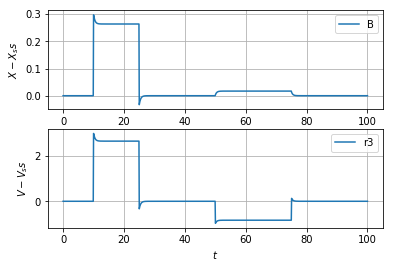

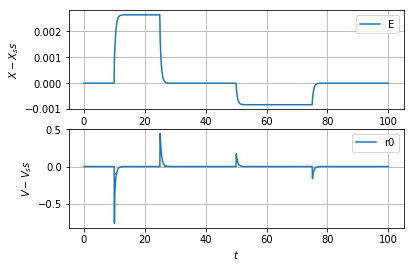

Text(0.5,0,'$t$')

Text(0,0.5,'$e_0$')

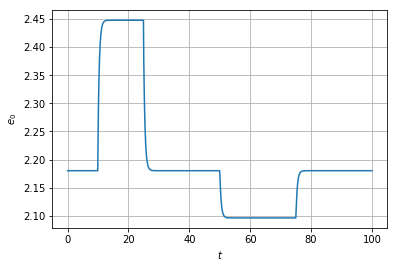

LINEAR SIMULATION


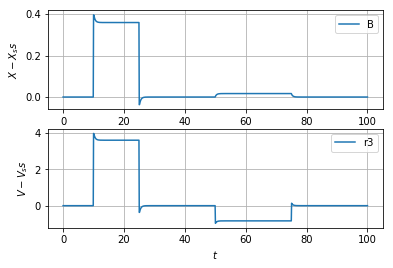

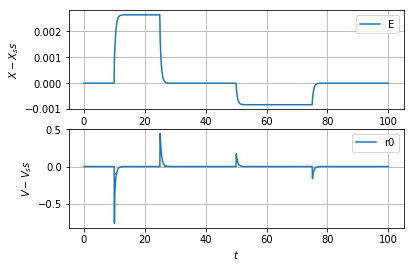

In [16]:
##Time
t_max = int(100)
t = np.linspace(0,t_max,1000)
t_0_0 = 10
t_1_0 = 25
t_0_d = 50
t_1_d = 75

step_0 = 1
step_d = 1
print('NON-LINEAR SIMULATION')
## Chemostat
chemo = '({0}+{1}*(np.heaviside(t-{2},1)-np.heaviside(t-{3},1)))'
x_chemo_0 =     chemo.format(parameter['X0_E0'],str(step_0),str(t_0_0),str(t_1_0))
x_chemo_b =     chemo.format(parameter['X0_B0'],str(step_d),str(t_0_d),str(t_1_d))

## Simulate
X_chemo = {'B0':x_chemo_b,'E0':x_chemo_0}
ndat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=x_ss,X_chemo=X_chemo,quiet=quiet)


##Plot
st.plot(s,ndat,species=['B'],reaction=['r3'],x_ss=x_ss,v_ss=v_ss)
st.plot(s,ndat,species=['E'],reaction=['r0'],x_ss=x_ss,v_ss=v_ss)

X = ndat['X']
X_E = X[:,s['species'].index('E')]
X_C = X[:,s['species'].index('C')]
e0 = X_E + X_C
plt.plot(t,e0)
plt.grid()
plt.xlabel('$t$')
plt.ylabel('$e_0$')
plt.show()

print('LINEAR SIMULATION')
## Chemostat
x_chemo_0 =     chemo.format('1e-6',str(step_0),str(t_0_0),str(t_1_0))
x_chemo_b =     chemo.format('1e-6',str(step_d),str(t_0_d),str(t_1_d))
X_chemo = {'B0':x_chemo_b,'E0':x_chemo_0}
ldat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=x_ss,X_chemo=X_chemo,linear=True,V0=v_ss,quiet=quiet)
st.plot(s,ldat,species=['B'],reaction=['r3'],x_ss=x_ss,v_ss=v_ss)
st.plot(s,ndat,species=['E'],reaction=['r0'],x_ss=x_ss,v_ss=v_ss)

## Discussion

- The non linear response has similar behaviour to the linear case although the values are different for a non-infinitesimal step.
- The net enzyme $e_0 = x_E+x_C$ is directly manipulated by the feedback system to adjust product flow driven by the actuator. 

# Conclusion

- A control-theoretical appoach via linearisation has been used to give insight into the behavior of a simple biomolecular system with product inhibition.

- Although linearisation is used to provide insights, the full non-linear system is still available for further analysis and simulation. In particular, energy flows are still available in the non-linear bond graph model.

- The role of *pumping* to endow the 'actuator' with desirable decoupling properties is emphasised.

- the feedback system has five chemostats: E0, F, G, A, B0. These can become ports to interact with the wider system. 

- it would be interesting to look at a real enzyme such as PFK.
